In [102]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import model_from_json

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

from covid_flu import config, utils, time_series, plotting,models

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction 

The goal of this exploration is to build recurrent neural networks (RNN) for forecasting flu rates across states and times. Our main goal is not find a state of the art model which can predict the next week with the highest accuracy. Instead, ultimately we want to build an accurate model for multi-step predictions. For instance, we argue that knowing in advance the projected rates for the next 5 weeks is important in this application, since it gives authorities the time needed to plan ahead projected spikes in flu activity. 

Given our goal, we are more interested in comparing different models in terms of how well they capture the patterns and less about hypermarameter tuning for finding the optimal parameters resulting in the lowest RMSE. Hence, in this analysis we are not focusing on finding the optimal architecture or hyperparameters but rather exploring different RNN models.

We will start from simple LSTM models and progressively move to more complex RNN structures. Specifically we explore:

- Simple LSTM for one step predictions.
- Simple LSTM with vector output for multi-step predictions
- Seq2Seq encoder-decoder architectures for multi-step predictions
- Seq2Seq with attention for multi-step predictions

## Loading clean data and scaling


In [74]:
df_flu = pd.read_csv(config.processed / 'flu_ground_truth_imputed.csv')
df_flu.head(5)

,time,wili,state
0,2010-40,2.06514,Texas
1,2010-41,2.09394,Texas
2,2010-42,2.10072,Texas
3,2010-43,2.20655,Texas
4,2010-44,2.36381,Texas


In [75]:
X = df_flu['wili'].values
groups = df_flu['state'].values
sc = StandardScaler()
X_scaled = sc.fit_transform(X.reshape(-1,1)).flatten()

In [32]:
#function to store a model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open(config.models / (model_name + '.json'), "w") as json_file:
        json_file.write(model_json)
    model.save_weights(str(config.models / (model_name + '.h5'))) # serialize weights to HDF5
    print("Saved model to disk")

## Simple LSTM for one step prediction

In this section we explore simple LSTM models which are provided a history of H weeks (e.g. 25 weeks) to predict the flu rate in next week.

In [4]:
HISTORY_SIZE = 25
TARGET_SIZE = 1

In [5]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

In [6]:
#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [7]:
def make_simple_lstm(history_length=25, target_length=1, num_lstm_layers=2, hidden_size=32, pre_output_dense_size=16):
    #builds simple lstm with variable length of hidden layers and 
    #one dense layer before the output layer
    
    simple_lstm = tf.keras.models.Sequential()
    for i in range(num_lstm_layers):
        if i==0:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', input_shape=(history_length,1), return_sequences=True))
        elif i==num_lstm_layers-1:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu'))
        else:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True))
    if pre_output_dense_size!=None:
        simple_lstm.add(layers.Dense(pre_output_dense_size, activation='relu'))
    simple_lstm.add(layers.Dense(target_length))
    simple_lstm.compile(optimizer='adam', loss='mse')
    return simple_lstm

In [8]:
simple_lstm = make_simple_lstm(num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)

In [9]:
simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_simplelstm = simple_lstm.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
68/68 [==============================] - 10s 150ms/step - loss: 0.6176 - val_loss: 0.0000e+00
Epoch 2/10
68/68 [==============================] - 6s 90ms/step - loss: 0.3077 - val_loss: 0.3358
Epoch 3/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1603 - val_loss: 0.1376
Epoch 4/10
68/68 [==============================] - 6s 90ms/step - loss: 0.1137 - val_loss: 0.1153
Epoch 5/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1047 - val_loss: 0.1145
Epoch 6/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1041 - val_loss: 0.1050
Epoch 7/10
68/68 [==============================] - 6s 90ms/step - loss: 0.1041 - val_loss: 0.1067
Epoch 8/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1002 - val_loss: 0.1206
Epoch 9/10
68/68 [==============================] - 6s 89ms/step - loss: 0.0998 - val_loss: 0.1120
Epoch 10/10
68/68 [==============================] - 6s 87ms/step - loss: 0.0995 - val_loss: 0.1091


In [11]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [12]:
def calc_rmse_model(y_true, x, model, history_length, scaler=None):
    #calculates unscaled RMSE for a model on a test set
    preds = model.predict(x)
    if scaler!=None:
        y_true = scaler.inverse_transform(y_true.flatten())
        preds = scaler.inverse_transform(preds)
    return calculate_rmse(y_true, preds)

In [13]:
calc_rmse_model(y_test, X_test, simple_lstm, HISTORY_SIZE, sc)

0.7526614831115344

A simple LSTM predicts next week's unscaled WILI rate, given past 25 weeks with **test set RMSE 0.752**.

In [25]:
def plot_preds_for_state(X_test, y_test, states_test, model, history_length, state, scaler=None):
    #plot of the predictions for a given state
    
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state].flatten()
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state].flatten())
        preds = scaler.inverse_transform(preds)
    
    print(f"RMSE = {calculate_rmse(y, preds)}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs Predicted for {state}')
    plt.show()

In [26]:
def plot_test_preds_for_all_states(X_test, y_test, states_test, model, history_length, suptitle, scaler=None):
    preds = model.predict(X_test)
    y = y_test.flatten()
    if scaler!=None:
        y = scaler.inverse_transform(y_test.flatten())
        preds = scaler.inverse_transform(preds)
    
    all_states = np.unique(states_test)
    fig, ax = plt.subplots(10, 5, figsize = (60,30))
    fig.suptitle(suptitle, y=0.99, fontsize=25)
    fig.subplots_adjust(top=0.94)
    
    for i, ax in enumerate(fig.axes):
        state = all_states[i]
        y_state = y[states_test==state]
        preds_state = preds[states_test==state]
        ax.plot(y_state, 'b-', label='True')
        ax.plot(preds_state, 'r-', label='Predicted')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('WILI')
        ax.set_title(f'True vs Predicted for {state}')
    
    plt.show()
    

Below we are plotting the predictions of the LSTM for a given state on a test set.

RMSE = 0.7329788809720756


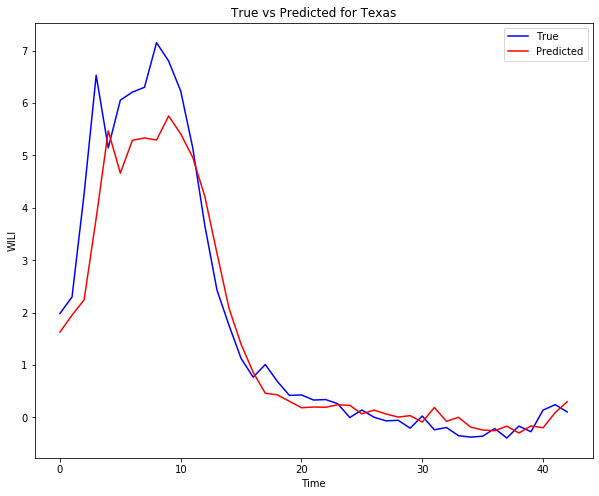

In [18]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm, HISTORY_SIZE, 'Texas')

Below we are plotting the predictions of the LSTM for the full time series of a given state (concatenation of train, validation and test set, last 20% of the time series is unseen).

In [19]:
X_all = np.concatenate((data_dict['X_train'],data_dict['X_val'], data_dict['X_test']))
y_all = np.concatenate((data_dict['y_train'],data_dict['y_val'], data_dict['y_test']))
states_all = np.concatenate((data_dict['states_train'],data_dict['states_val'], data_dict['states_test']))

RMSE = 0.4468617340766393


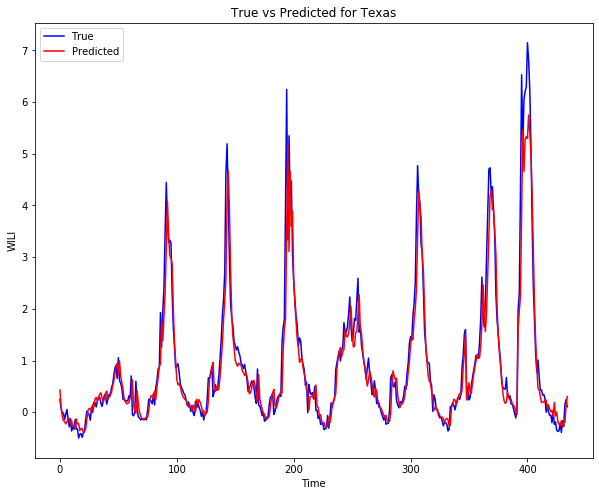

In [20]:
plot_preds_for_state(X_all, y_all, states_all, simple_lstm, HISTORY_SIZE, 'Texas')


In [33]:
store_keras_model(simple_lstm, 'simple_lstm_25_1')

Saved model to disk


### Does history size play a role in predictions?

Below we fitting different simple LSTM models for varying history sizes. 

#### History of 10 weeks

In [34]:
HISTORY_SIZE = 10
TARGET_SIZE = 1

In [35]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

In [36]:
#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [37]:
simple_lstm10 = make_simple_lstm(history_length=HISTORY_SIZE, target_length=TARGET_SIZE,
                                 num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)


In [38]:
simple_lstm10.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
71/71 [==============================] - 7s 95ms/step - loss: 0.6220 - val_loss: 0.0000e+00
Epoch 2/10
71/71 [==============================] - 3s 39ms/step - loss: 0.2146 - val_loss: 0.1278
Epoch 3/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1376 - val_loss: 0.1106
Epoch 4/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1136 - val_loss: 0.1185
Epoch 5/10
71/71 [==============================] - 3s 40ms/step - loss: 0.1090 - val_loss: 0.1145
Epoch 6/10
71/71 [==============================] - 3s 40ms/step - loss: 0.1091 - val_loss: 0.1135
Epoch 7/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1084 - val_loss: 0.1116
Epoch 8/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1110 - val_loss: 0.1098
Epoch 9/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1108 - val_loss: 0.1060
Epoch 10/10
71/71 [==============================] - 3s 39ms/step - loss: 0.1096 - val_loss: 0.1174


In [39]:
calc_rmse_model(y_test, X_test, simple_lstm10, HISTORY_SIZE, sc)

0.7982507049936505

#### History of 50 weeks

In [41]:
HISTORY_SIZE = 50
TARGET_SIZE = 1

ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size = 0.2,
                                                                batch_size = 256
                                                               )

#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [42]:
simple_lstm50 = make_simple_lstm(history_length=HISTORY_SIZE, target_length=TARGET_SIZE,
                                 num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)


In [43]:
simple_lstm50.fit(ds_train, epochs=10, validation_data=ds_val)


Epoch 1/10
65/65 [==============================] - 15s 228ms/step - loss: 0.6344 - val_loss: 0.0000e+00
Epoch 2/10
65/65 [==============================] - 11s 167ms/step - loss: 0.3417 - val_loss: 0.3478
Epoch 3/10
65/65 [==============================] - 11s 167ms/step - loss: 0.2040 - val_loss: 0.1356
Epoch 4/10
65/65 [==============================] - 11s 164ms/step - loss: 0.1307 - val_loss: 0.1181
Epoch 5/10
65/65 [==============================] - 11s 167ms/step - loss: 0.1165 - val_loss: 0.0995
Epoch 6/10
65/65 [==============================] - 11s 167ms/step - loss: 0.1106 - val_loss: 0.1072
Epoch 7/10
65/65 [==============================] - 11s 166ms/step - loss: 0.1097 - val_loss: 0.1280
Epoch 8/10
65/65 [==============================] - 11s 164ms/step - loss: 0.1086 - val_loss: 0.1048
Epoch 9/10
65/65 [==============================] - 11s 168ms/step - loss: 0.1069 - val_loss: 0.0933
Epoch 10/10
65/65 [==============================] - 11s 167ms/step - loss: 0.1128 - va

In [44]:
calc_rmse_model(y_test, X_test, simple_lstm50, HISTORY_SIZE, sc)

0.6869024550701199

A longer history of 50 weeks works well for predicting the next week resulting in significantly lower RMSE across states (0.686 compared to 0.75 for 25 weeks and 0.79 for 10 weeks of history).

In [45]:
store_keras_model(simple_lstm50, 'simple_lstm_50_1')

Saved model to disk


RMSE = 0.28383644685259274


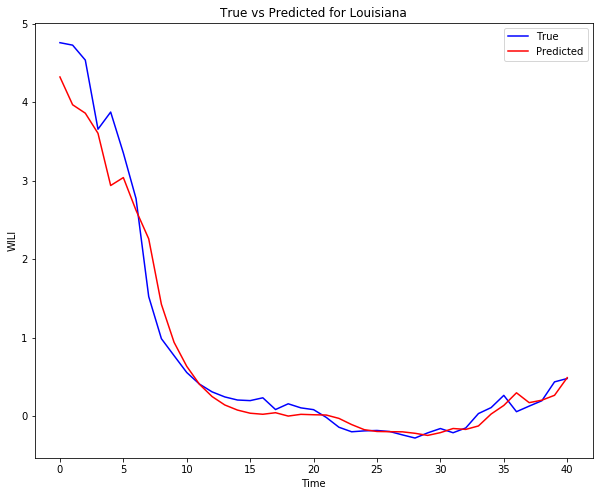

In [46]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm50, HISTORY_SIZE, 'Louisiana')

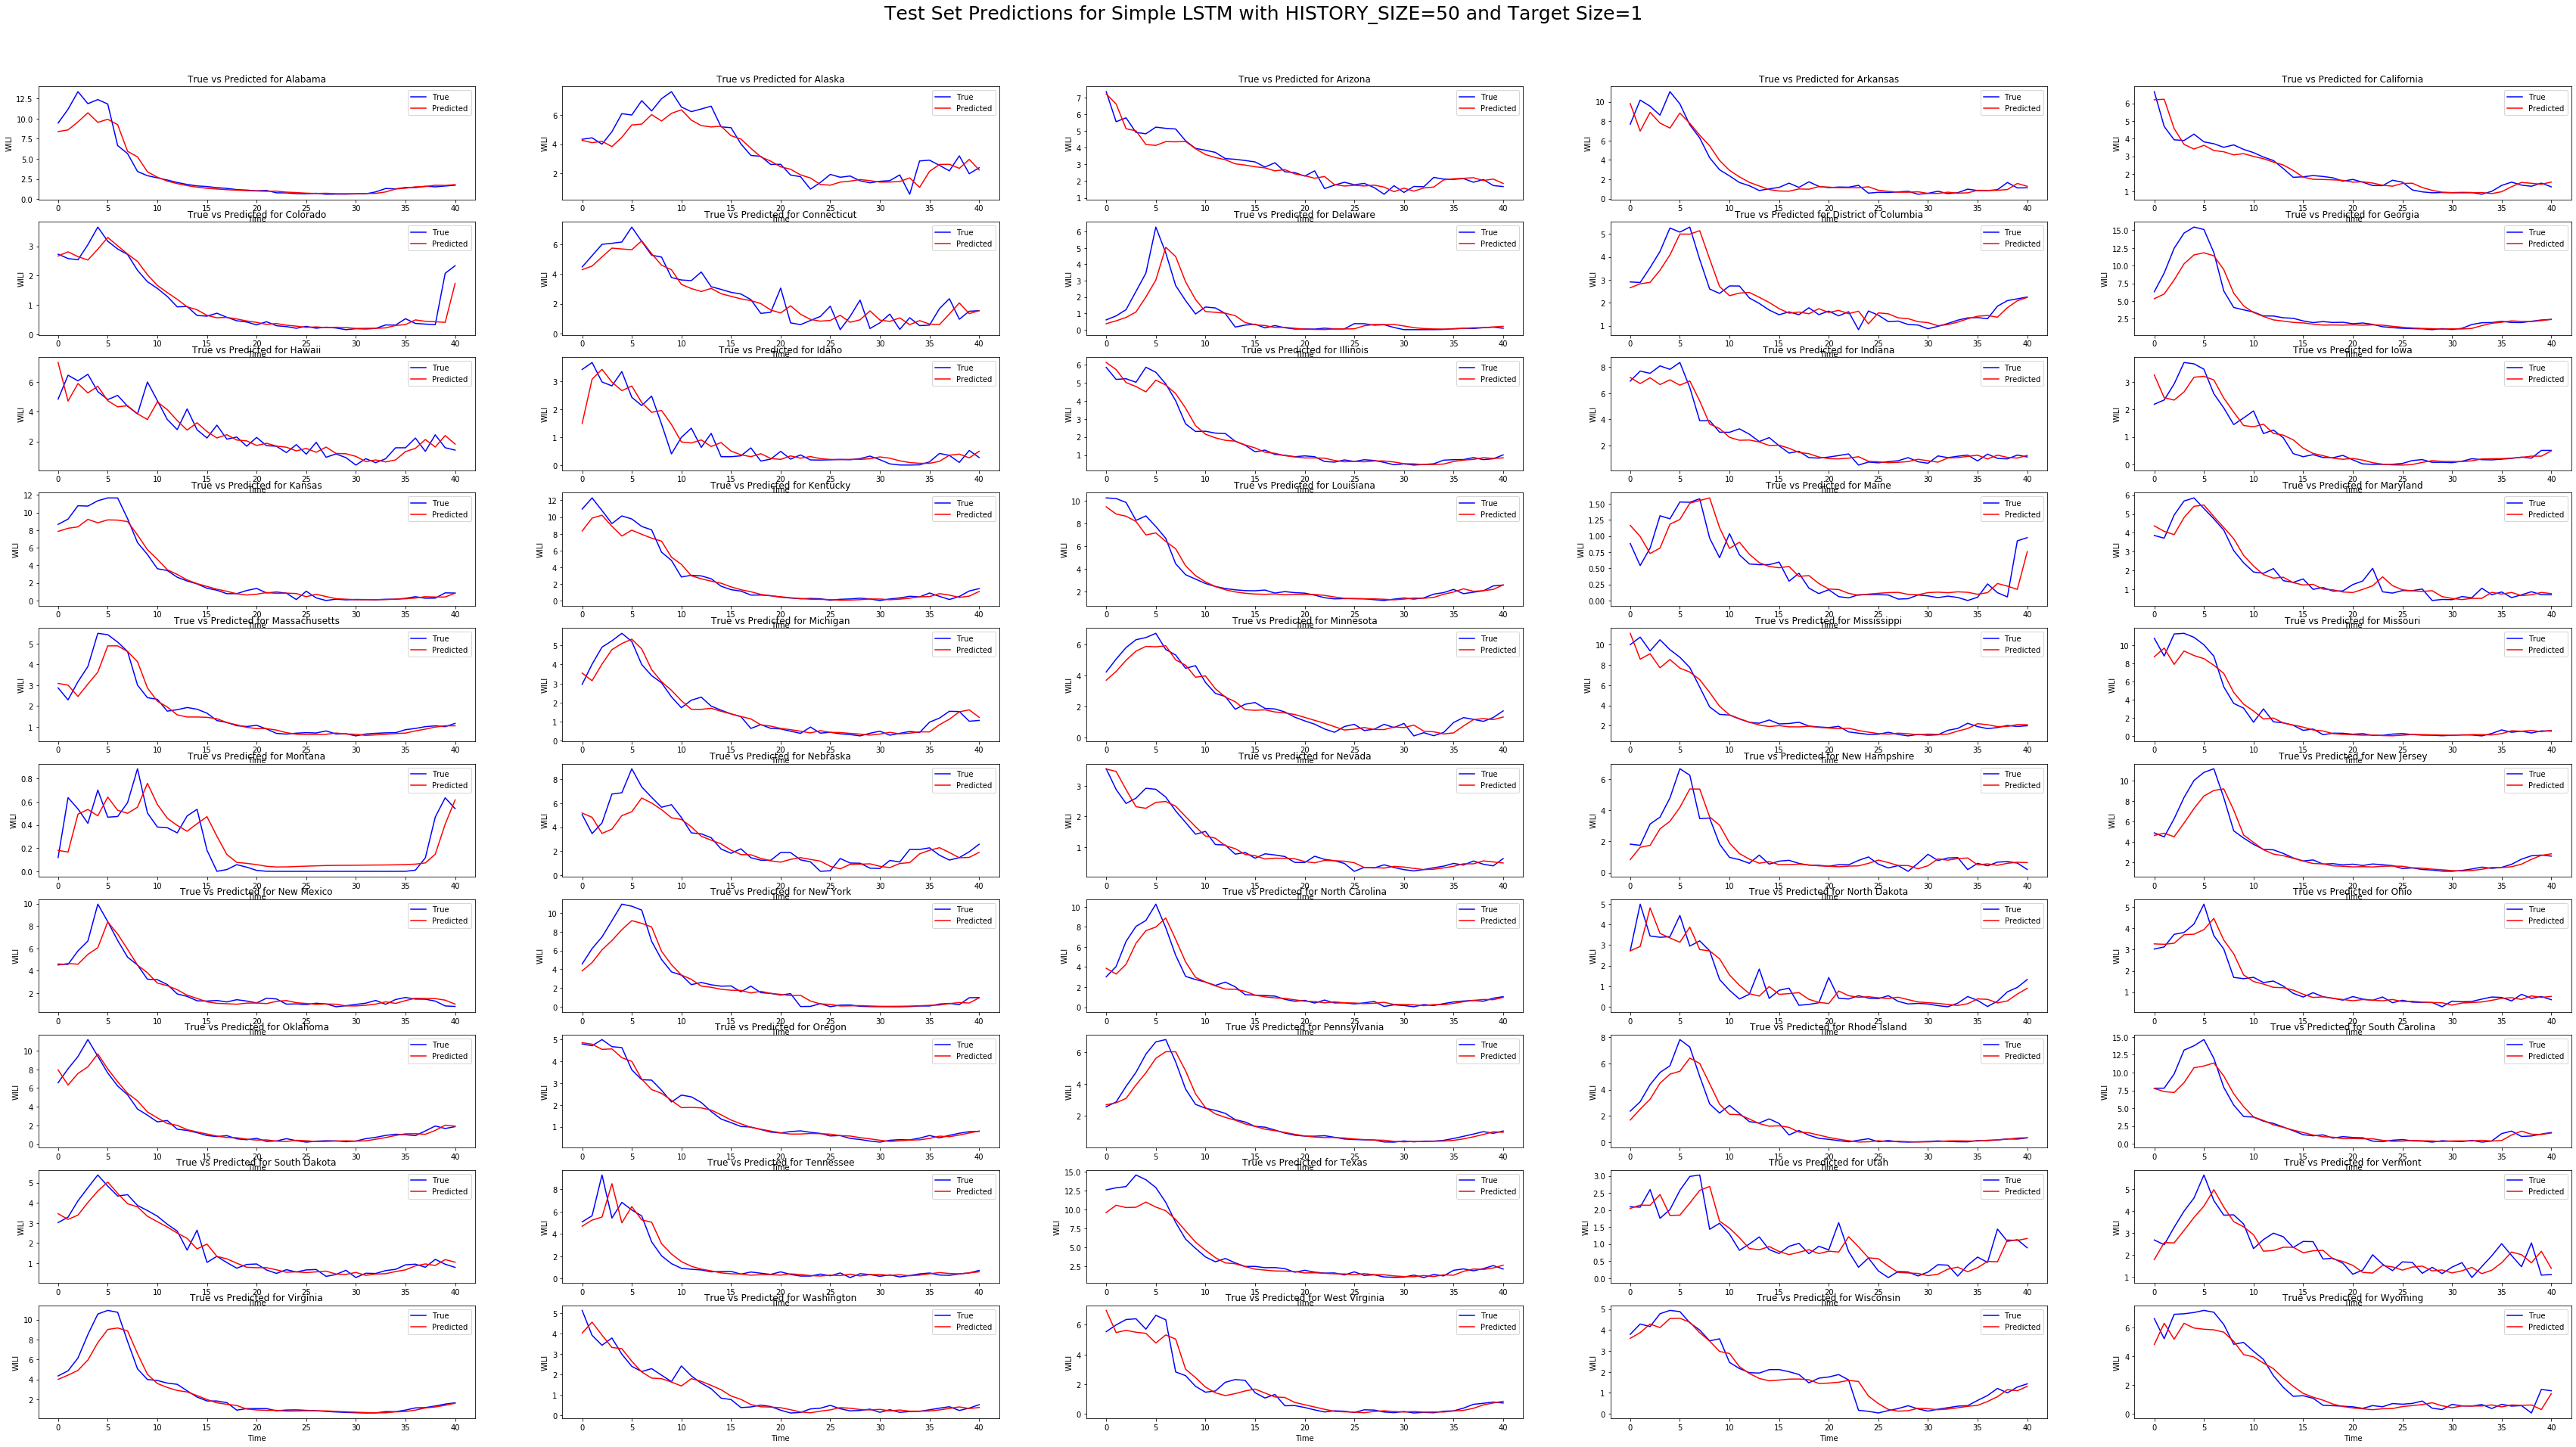

In [47]:
plot_test_preds_for_all_states(X_test, y_test, states_test, simple_lstm50, HISTORY_SIZE,
                               "Test Set Predictions for Simple LSTM with HISTORY_SIZE=50 and Target Size=1", scaler=sc)


As observed above, a simple LSTM model makes decent one-step predictions across states given a history of 50 weeks.

In [160]:
store_keras_model(simple_lstm50, 'simple_lstm_50_1')

Saved model to disk


## Multi-step time series forecasting

The goal of this section is to predict next T weeks (e.g. 5 weeks) given H previous weeks (e.g. 50 weeks).

In this task we want to evaluate the model on how well it is able to predict the next couple of weeks. Hence we measure the RMSE for each of the next T steps of the multi-step prediction. This will allows us to see which models have better predictive accuracy at different lead times (e.g. +1 week vs +4 weeks).

### Creating data for multi-step predictions

Below, we adjust the training data to pairs (X,y), where X is a H-week history vector and y is T-future-weeks target vector.

In [55]:
HISTORY_SIZE = 25
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [56]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [57]:
X_test.shape

(2150, 25, 1)

In [58]:
y_test.shape

(2150, 5, 1)

## Simple LSTM with vector output 

#### History of 25 weeks to predict next 5 weeks


In [59]:
simple_lstm_multi = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [60]:
simple_lstm_multi.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 25, 32)            8320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 22,213
Trainable params: 22,213
Non-trainable params: 0
_________________________________________________________________


In [61]:
simple_lstm_multi.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
269/269 [==============================] - 27s 101ms/step - loss: 0.4835 - val_loss: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 23s 85ms/step - loss: 0.2675 - val_loss: 0.3785
Epoch 3/10
269/269 [==============================] - 23s 86ms/step - loss: 0.2547 - val_loss: 0.3781
Epoch 4/10
269/269 [==============================] - 23s 85ms/step - loss: 0.2483 - val_loss: 0.3620
Epoch 5/10
269/269 [==============================] - 23s 85ms/step - loss: 0.2481 - val_loss: 0.3523
Epoch 6/10
269/269 [==============================] - 23s 86ms/step - loss: 0.2408 - val_loss: 0.3271
Epoch 7/10
269/269 [==============================] - 23s 85ms/step - loss: 0.2359 - val_loss: 0.3291
Epoch 8/10
269/269 [==============================] - 23s 86ms/step - loss: 0.2322 - val_loss: 0.3397
Epoch 9/10
269/269 [==============================] - 23s 85ms/step - loss: 0.2299 - val_loss: 0.3325
Epoch 10/10
269/269 [==============================] - 23s 86ms/step - loss: 

In [62]:
def evaluate_multiple_steps_preds(y_true, X, model, target_size, scaler):
    #calculate the rmse for each for each of the 
    #steps individualy (i.e. error for one week ahead, 2 weeks ahead and so on)
    
    predicted = model.predict(X).reshape(-1,target_size)
    y_true = y_true.reshape(-1,target_size)

    if scaler!=None:
        y_true = scaler.inverse_transform(y_true)
        predicted = scaler.inverse_transform(predicted)
    rmses = []
    for i in range(predicted.shape[1]):
        rmse_step = calculate_rmse(y_true[:,i], predicted[:,i])
        rmses.append(rmse_step)
    rmses = np.array(rmses)
    return rmses, rmses.mean()

Below we evaluate the RMSE for each step of the prediction as well as the average RMSE across the prediction steps. 

In [64]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi, TARGET_SIZE, sc)


(array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
 1.4112976472394598)

In [65]:
results_multi = {}
results_multi['simple_lstm_5_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi, TARGET_SIZE, sc)

In [66]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
  1.4112976472394598)}

In [67]:
def plot_multiple_steps_preds_for_state(X_test, y_test, states_test, model, target_size, state, scaler=None):
    #plot the preds for target_size weeks ahead skipping every target_size inputs 
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state]
    rmses, mean_rmse = evaluate_multiple_steps_preds(y, X_test[states_test==state], model, target_size, scaler)
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state])
        preds = scaler.inverse_transform(preds)
    
    multiple_step_preds = preds[::target_size,:].flatten()
    y = y[::target_size, :].flatten()
    
    print(f"RMSES for each step = {rmses}, average = {mean_rmse}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(multiple_step_preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs {target_size}-steps prediction for {state}')
    plt.show()

Below we are plotting the predictions of the model for 5 weeks into the future. We want to understand whether the model captures the pattern for the next weeks ahead. For this reason, we set the first point in time on the test set as $t$ and we predict the WILI rate for next 5 weeks from this point given a history of 25 weeks. We form the first piece of the red line by connecting the predictions for the next 5 weeks. Then we skip the next 5 weeks and we repeat the process for predicting the next 5 weeks by knowing all the information up to $t+5$ weeks, to get another line of 5-week predictions. Finally we connect all these lines to form the entire red line which shows how well the model predicted the trends 5 weeks ahead.

RMSES for each step = [0.89689745 1.35123235 1.77206242 2.10173093 2.3748904 ], average = 1.6993627104218745


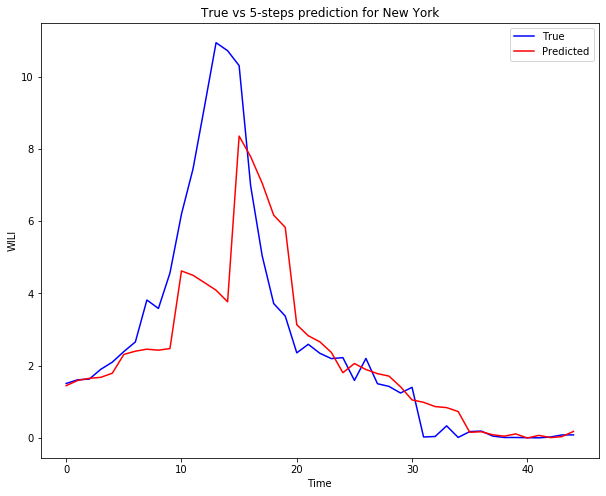

In [68]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi, TARGET_SIZE, 'New York', sc)

#### History of 50 weeks to predict next 5 weeks


In [78]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [79]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [80]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))

In [72]:
simple_lstm_multi50 = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [81]:
simple_lstm_multi50.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
254/254 [==============================] - 41s 162ms/step - loss: 0.8037 - val_loss: 0.0000e+00
Epoch 2/10
254/254 [==============================] - 41s 161ms/step - loss: 0.7909 - val_loss: 1.1944
Epoch 3/10
254/254 [==============================] - 41s 160ms/step - loss: 0.7800 - val_loss: 1.1889
Epoch 4/10
254/254 [==============================] - 41s 161ms/step - loss: 0.7541 - val_loss: 1.1659
Epoch 5/10
254/254 [==============================] - 41s 161ms/step - loss: 0.6876 - val_loss: 0.9405
Epoch 6/10
254/254 [==============================] - 41s 160ms/step - loss: 0.5989 - val_loss: 0.8795
Epoch 7/10
254/254 [==============================] - 41s 160ms/step - loss: 0.4983 - val_loss: 0.6970
Epoch 8/10
254/254 [==============================] - 41s 161ms/step - loss: 0.4274 - val_loss: 0.6272
Epoch 9/10
254/254 [==============================] - 41s 161ms/step - loss: 0.3855 - val_loss: 0.5792
Epoch 10/10
254/254 [==============================] - 41s 160ms/step

In [82]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50, TARGET_SIZE, sc)


(array([1.27137708, 1.46628964, 1.67468811, 1.77170383, 1.78320891]),
 1.5934535134923014)

In [83]:
results_multi['simple_lstm50_5_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50, TARGET_SIZE, sc)

In [84]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
  1.4112976472394598),
 'simple_lstm50_5_weeks_preds': (array([1.27137708, 1.46628964, 1.67468811, 1.77170383, 1.78320891]),
  1.5934535134923014)}

Below we plot 5-step predictions on test set as well as on the whole time series for a given state.

RMSES for each step = [1.31948203 1.70980589 2.17511164 2.32626733 2.54986897], average = 2.0161071727832995


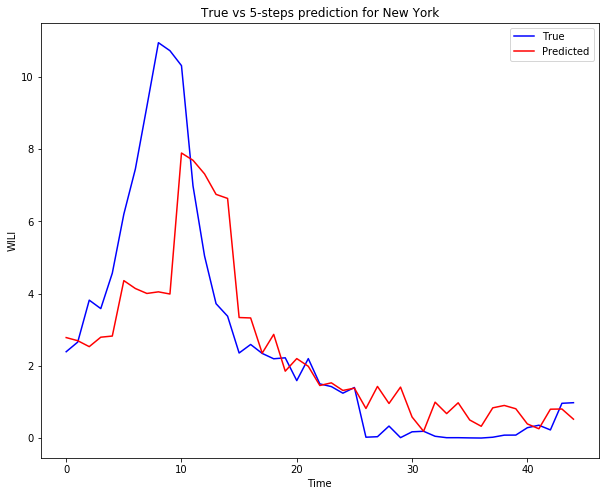

In [85]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi50, TARGET_SIZE, 'New York', sc)


RMSES for each step = [0.79170905 0.9212497  1.13640893 1.1900825  1.28715821], average = 1.065321676946089


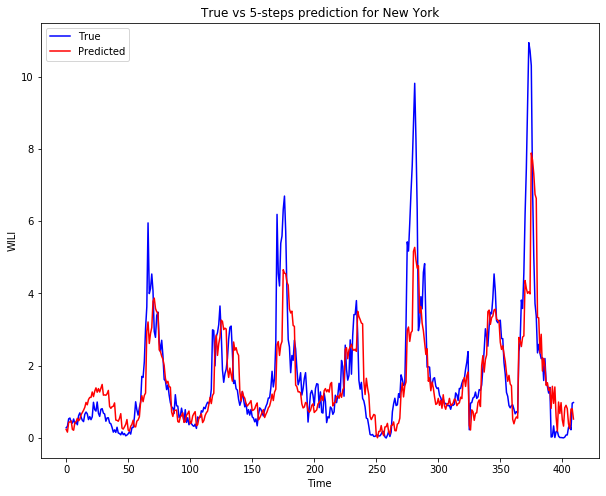

In [86]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_lstm_multi50, TARGET_SIZE, 'New York', sc)


#### History of 50 weeks to predict next 10 weeks

In [87]:
HISTORY_SIZE = 50
TARGET_SIZE = 10

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2)

In [88]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [89]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))

In [90]:
simple_lstm_multi50_10 = make_simple_lstm(history_length=HISTORY_SIZE, 
                                     target_length=TARGET_SIZE, 
                                     num_lstm_layers=3, 
                                     hidden_size=32, 
                                     pre_output_dense_size=32)

In [91]:
simple_lstm_multi50_10.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
250/250 [==============================] - 43s 172ms/step - loss: 0.6767 - val_loss: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 39s 158ms/step - loss: 0.3833 - val_loss: 0.4755
Epoch 3/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3310 - val_loss: 0.4518
Epoch 4/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3191 - val_loss: 0.3762
Epoch 5/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3047 - val_loss: 0.5105
Epoch 6/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3124 - val_loss: 0.4114
Epoch 7/10
250/250 [==============================] - 40s 158ms/step - loss: 0.2955 - val_loss: 0.3887
Epoch 8/10
250/250 [==============================] - 39s 157ms/step - loss: 0.2956 - val_loss: 0.4537
Epoch 9/10
250/250 [==============================] - 39s 157ms/step - loss: 0.2877 - val_loss: 0.4633
Epoch 10/10
250/250 [==============================] - 39s 157ms/step

In [92]:
evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50_10, TARGET_SIZE, sc)


(array([0.97797889, 1.20924262, 1.37136815, 1.49777479, 1.60570331,
        1.71059057, 1.78296277, 1.77210993, 1.75792201, 1.70661152]),
 1.53922645575781)

In [93]:
results_multi['simple_lstm50_10_weeks_preds'] = evaluate_multiple_steps_preds(y_test, X_test, simple_lstm_multi50_10, TARGET_SIZE, sc)


In [94]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
  1.4112976472394598),
 'simple_lstm50_5_weeks_preds': (array([1.27137708, 1.46628964, 1.67468811, 1.77170383, 1.78320891]),
  1.5934535134923014),
 'simple_lstm50_10_weeks_preds': (array([0.97797889, 1.20924262, 1.37136815, 1.49777479, 1.60570331,
         1.71059057, 1.78296277, 1.77210993, 1.75792201, 1.70661152]),
  1.53922645575781)}

RMSES for each step = [0.67759129 0.86871066 0.96667481 1.03266348 1.08860487 1.14358395
 1.21813616 1.2478504  1.30703611 1.33722353], average = 1.0888075266807873


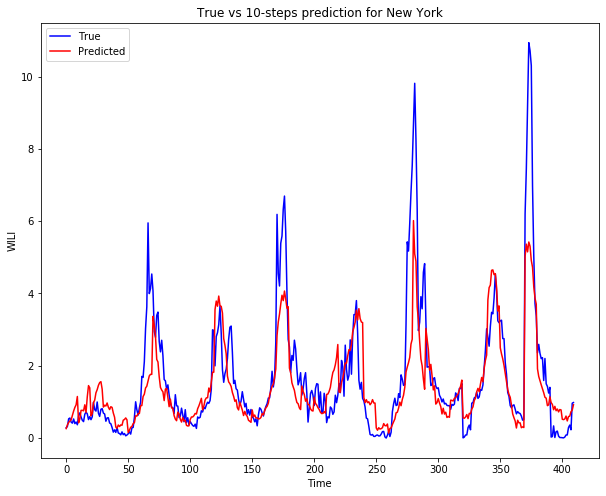

In [95]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_lstm_multi50_10, TARGET_SIZE, 'New York', sc)


## Seq2Seq models for multi-step predictions


### Simple encoder-decoder model

First we will try to build a model for 5-week predictions and then we will test performance for 10-week predictions.

#### History of 50 weeks to predict next 5 weeks


In [123]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [124]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [109]:
seq2seq_model = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=2,
                               num_decoder_layers=1,
                               pre_output_dense_size=16
                               )

In [110]:
seq2seq_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
encoder_lstm (RNN)              [(None, 50, 32), [(N 12672       input_8[0][0]                    
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 32), ( 4352        input_9[0][0]                    
                                                                 encoder_lstm[0][2]         

In [111]:
seq2seq_model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
254/254 [==============================] - 23s 89ms/step - loss: 0.2504 - val_loss: 0.0000e+00
Epoch 2/10
254/254 [==============================] - 18s 72ms/step - loss: 0.1087 - val_loss: 0.1150
Epoch 3/10
254/254 [==============================] - 19s 73ms/step - loss: 0.1029 - val_loss: 0.1079
Epoch 4/10
254/254 [==============================] - 18s 72ms/step - loss: 0.0998 - val_loss: 0.1028
Epoch 5/10
254/254 [==============================] - 18s 72ms/step - loss: 0.0988 - val_loss: 0.1051
Epoch 6/10
254/254 [==============================] - 18s 72ms/step - loss: 0.0971 - val_loss: 0.1067
Epoch 7/10
254/254 [==============================] - 18s 73ms/step - loss: 0.0970 - val_loss: 0.1095
Epoch 8/10
254/254 [==============================] - 18s 72ms/step - loss: 0.0971 - val_loss: 0.1077
Epoch 9/10
254/254 [==============================] - 18s 72ms/step - loss: 0.0956 - val_loss: 0.1090
Epoch 10/10
254/254 [==============================] - 18s 72ms/step - loss: 0

In [39]:
def predict_seq2seq(X, model, target_size):
    preds = []
    for i in range(X.shape[0]):
        pred = model.decode_sequence(X[i], target_size).reshape((-1, target_size))
        preds.extend(pred)
    preds = np.stack(preds, axis=0)
    return preds

In [40]:
def evaluate_multiple_steps_preds_seq2seq(y_true, X, model, target_size, scaler):
    #calculate the rmse for each for each of the 
    #steps individualy (i.e. error for one week ahead, 2 weeks ahead and so on)
    
    predicted = predict_seq2seq(X, model, target_size)
    y_true = y_true.reshape(-1,target_size)

    if scaler!=None:
        y_true = scaler.inverse_transform(y_true)
        predicted = scaler.inverse_transform(predicted)
    rmses = []
    for i in range(predicted.shape[1]):
        rmse_step = calculate_rmse(y_true[:,i], predicted[:,i])
        rmses.append(rmse_step)
    rmses = np.array(rmses)
    return rmses, rmses.mean()

In [114]:
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model, TARGET_SIZE, sc)


(array([0.76380978, 1.08269077, 1.28624057, 1.38419171, 1.40675542]),
 1.1847376489309354)

In [125]:
results_multi['seq2seq_50_5'] = evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model, TARGET_SIZE, sc)

In [176]:
seq2seq_model.encoder_model.save_weights('test.h5')

RuntimeError: Unable to create link (name already exists)

In [171]:
store_keras_model(seq2seq_model.encoder_model, 'seq2seq_50_5_encoder')

RuntimeError: Unable to create link (name already exists)

In [175]:
store_keras_model(seq2seq_model.encoder_model, 'test')

RuntimeError: Unable to create link (name already exists)

#### History of 50 weeks to predict next 10 weeks


In [126]:
HISTORY_SIZE = 50
TARGET_SIZE = 10

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [127]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [118]:
seq2seq_model_10steps = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=2,
                               num_decoder_layers=1,
                               pre_output_dense_size=16
                               )

In [119]:
seq2seq_model_10steps.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
250/250 [==============================] - 23s 94ms/step - loss: 0.2096 - val_loss: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 18s 74ms/step - loss: 0.1045 - val_loss: 0.1160
Epoch 3/10
250/250 [==============================] - 19s 74ms/step - loss: 0.1007 - val_loss: 0.1107
Epoch 4/10
250/250 [==============================] - 19s 75ms/step - loss: 0.0990 - val_loss: 0.1009
Epoch 5/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0973 - val_loss: 0.1049
Epoch 6/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0966 - val_loss: 0.1006
Epoch 7/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0958 - val_loss: 0.1118
Epoch 8/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0951 - val_loss: 0.1039
Epoch 9/10
250/250 [==============================] - 18s 73ms/step - loss: 0.0943 - val_loss: 0.1030
Epoch 10/10
250/250 [==============================] - 18s 73ms/step - loss: 0

In [121]:
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_10steps, TARGET_SIZE, sc)


(array([0.73894535, 1.03196952, 1.20630903, 1.32828495, 1.41924158,
        1.49037235, 1.53268853, 1.52070261, 1.48212798, 1.45687217]),
 1.3207514076588234)

In [128]:
results_multi['seq2seq_50_10'] = evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_10steps, TARGET_SIZE, sc)


In [129]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
  1.4112976472394598),
 'simple_lstm50_5_weeks_preds': (array([1.27137708, 1.46628964, 1.67468811, 1.77170383, 1.78320891]),
  1.5934535134923014),
 'simple_lstm50_10_weeks_preds': (array([0.97797889, 1.20924262, 1.37136815, 1.49777479, 1.60570331,
         1.71059057, 1.78296277, 1.77210993, 1.75792201, 1.70661152]),
  1.53922645575781),
 'seq2seq_50_5': (array([0.76380978, 1.08269077, 1.28624057, 1.38419171, 1.40675542]),
  1.1847376489309354),
 'seq2seq_50_10': (array([0.73894535, 1.03196952, 1.20630903, 1.32828495, 1.41924158,
         1.49037235, 1.53268853, 1.52070261, 1.48212798, 1.45687217]),
  1.3207514076588234)}

In [ ]:
store_keras_model(seq2seq_model_10steps, 'seq2seq_model_50_10')

### Encoder-decoder model with Attention mechanism

#### History of 50 weeks to predict next 5 weeks

In [142]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [143]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [144]:
seq2seq_model_att_5steps = models.build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=2,
                               num_decoder_layers=1,
                               pre_output_dense_size=16
                               )

In [145]:
seq2seq_model_att_5steps.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 50, 1)]           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 50, 32)            4352      
_________________________________________________________________
lstm_28 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
attention_2 (Attention)      (None, 32)                82        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 32)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
dense_18 (Dense)             (None, 5, 16)             528

In [146]:
seq2seq_model_att_5steps.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
254/254 [==============================] - 37s 145ms/step - loss: 0.6926 - val_loss: 0.0000e+00
Epoch 2/10
254/254 [==============================] - 32s 125ms/step - loss: 0.5238 - val_loss: 0.8352
Epoch 3/10
254/254 [==============================] - 32s 126ms/step - loss: 0.4737 - val_loss: 0.5634
Epoch 4/10
254/254 [==============================] - 32s 125ms/step - loss: 0.4331 - val_loss: 0.5610
Epoch 5/10
254/254 [==============================] - 32s 126ms/step - loss: 0.3769 - val_loss: 0.4230
Epoch 6/10
254/254 [==============================] - 32s 126ms/step - loss: 0.3125 - val_loss: 0.3692
Epoch 7/10
254/254 [==============================] - 32s 126ms/step - loss: 0.2676 - val_loss: 0.3404
Epoch 8/10
254/254 [==============================] - 32s 126ms/step - loss: 0.2471 - val_loss: 0.3820
Epoch 9/10
254/254 [==============================] - 32s 126ms/step - loss: 0.2377 - val_loss: 0.4183
Epoch 10/10
254/254 [==============================] - 32s 125ms/step

In [152]:
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_att_5steps, TARGET_SIZE, sc)


(array([0.93706291, 1.14933564, 1.31230772, 1.41993878, 1.46091527]),
 1.2559120661684982)

In [153]:
results_multi['seq2seq_model_att_5steps'] = \
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_att_5steps, TARGET_SIZE, sc)


#### History of 50 weeks to predict next 10 weeks

In [162]:
HISTORY_SIZE = 50
TARGET_SIZE = 10

ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.2,
                                             teacher_forcing=True                       
                                             )

In [163]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [164]:
seq2seq_model_att_10steps = models.build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=32,
                               num_encoder_layers=2,
                               num_decoder_layers=1,
                               pre_output_dense_size=16
                               )

In [165]:
seq2seq_model_att_10steps.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 50, 1)]           0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 50, 32)            4352      
_________________________________________________________________
lstm_34 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
attention_4 (Attention)      (None, 32)                82        
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 10, 32)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 10, 32)            8320      
_________________________________________________________________
dense_22 (Dense)             (None, 10, 16)            528

In [166]:
seq2seq_model_att_10steps.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
250/250 [==============================] - 36s 143ms/step - loss: 0.8080 - val_loss: 0.0000e+00
Epoch 2/10
250/250 [==============================] - 32s 127ms/step - loss: 0.5474 - val_loss: 0.7478
Epoch 3/10
250/250 [==============================] - 32s 127ms/step - loss: 0.5045 - val_loss: 0.6373
Epoch 4/10
250/250 [==============================] - 32s 127ms/step - loss: 0.4732 - val_loss: 0.5782
Epoch 5/10
250/250 [==============================] - 32s 127ms/step - loss: 0.4426 - val_loss: 0.4893
Epoch 6/10
250/250 [==============================] - 32s 127ms/step - loss: 0.3933 - val_loss: 0.5186
Epoch 7/10
250/250 [==============================] - 31s 126ms/step - loss: 0.3561 - val_loss: 0.5895
Epoch 8/10
250/250 [==============================] - 31s 126ms/step - loss: 0.3321 - val_loss: 0.4328
Epoch 9/10
250/250 [==============================] - 32s 126ms/step - loss: 0.3303 - val_loss: 0.4049
Epoch 10/10
250/250 [==============================] - 32s 126ms/step

In [167]:
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_att_10steps, TARGET_SIZE, sc)

(array([1.34104715, 1.39421864, 1.53337743, 1.63953915, 1.72063066,
        1.77796536, 1.80702287, 1.77866724, 1.70663682, 1.65022875]),
 1.6349334076657953)

In [169]:
results_multi['seq2seq_model_att_10steps'] = \
evaluate_multiple_steps_preds(y_test, X_test, seq2seq_model_att_10steps, TARGET_SIZE, sc)


In [177]:
results_multi

{'simple_lstm_5_weeks_preds': (array([0.87200536, 1.18462266, 1.45150802, 1.68467384, 1.86367836]),
  1.4112976472394598),
 'simple_lstm50_5_weeks_preds': (array([1.27137708, 1.46628964, 1.67468811, 1.77170383, 1.78320891]),
  1.5934535134923014),
 'simple_lstm50_10_weeks_preds': (array([0.97797889, 1.20924262, 1.37136815, 1.49777479, 1.60570331,
         1.71059057, 1.78296277, 1.77210993, 1.75792201, 1.70661152]),
  1.53922645575781),
 'seq2seq_50_5': (array([0.76380978, 1.08269077, 1.28624057, 1.38419171, 1.40675542]),
  1.1847376489309354),
 'seq2seq_50_10': (array([0.73894535, 1.03196952, 1.20630903, 1.32828495, 1.41924158,
         1.49037235, 1.53268853, 1.52070261, 1.48212798, 1.45687217]),
  1.3207514076588234),
 'seq2seq_model_att_5steps': (array([0.93706291, 1.14933564, 1.31230772, 1.41993878, 1.46091527]),
  1.2559120661684982),
 'seq2seq_model_att_10steps': (array([1.34104715, 1.39421864, 1.53337743, 1.63953915, 1.72063066,
         1.77796536, 1.80702287, 1.77866724, 1.70